In [22]:
import pandas as pd
import plotly

In [23]:
df = pd.read_excel("Clustering Dataset Definitivo.xlsx")

In [5]:
df1 = df[['product_id', 'review_score','customer_unique_id']]

In [6]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df1['review_score'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} items-rating'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [7]:
data = df1.groupby('product_id')['review_score'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [8]:
df1.groupby('product_id')['review_score'].count().reset_index().sort_values('review_score', ascending=False)[:10]

,product_id,review_score
19497,99a4788cb24856965c36a24e339b6058,493
21838,aca2eb7d00ea1a7b8ebd4e68314663af,437
8487,422879e10f46682990de24d770e7f83d,368
26711,d1c427060a0f73f6b889a5c7c61f2ac4,334
7258,389d119b48cf3043d311335e499d9c6b,319
10716,53b36df67ebb7c41585e8d54d6772e08,307
10690,53759a2ecddad2bb87a079a1f1519f73,301
6982,368c6c730842d78016ad823897a372db,295
2759,154e7e31ebfa092203795c972e5804a6,270
5618,2b4609f8948be18874494203496bc318,265


In [9]:
data = df1.groupby('customer_unique_id')['review_score'].count().clip(upper=25)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 25)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [10]:
df1.groupby('customer_unique_id')['review_score'].count().reset_index().sort_values('review_score', ascending=False)[:10]

,customer_unique_id,review_score
56798,9a736b248f67d166d2fbb006bcb877c3,54
51059,8af7ac63b2efbcbd88e5b11505e8098a,29
31902,569aa12b73b5f7edeaa6f2a01603e381,26
80592,db1af3fd6b23ac3873ef02619d548f9c,24
91746,f9ae226291893fda10af7965268fb7f6,23
13730,2524dcec233c3766f2c2b22f69fd65f4,22
87327,ed917c786a8a3e411eae87aeca27cb27,20
20678,3806104dbbc3d14c17b091b3b8e38d59,20
13647,24f12460aad399ba18f4ed2c2fbab65d,19
41142,6fbc7cdadbb522125f4b27ae9dee4060,19


In [11]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import CoClustering
from surprise.model_selection import cross_validate

In [12]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df1[['customer_unique_id', 'product_id', 'review_score']], reader)
data

In [13]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.333320,3.827191,0.124182
SVDpp,1.336053,4.665276,0.202666
BaselineOnly,1.342988,0.236909,0.114893
SlopeOne,1.347517,14.638186,0.180075
NMF,1.349692,8.061591,0.128463
CoClustering,1.359011,5.221506,0.170934
NormalPredictor,1.717076,0.062397,0.203652


In [14]:
print('Using ALS')
SVD_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = SVD()
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS


{'test_rmse': array([1.32952567, 1.33309778, 1.33772703]),
 'fit_time': (3.9099481105804443, 3.8925788402557373, 3.8868048191070557),
 'test_time': (0.1255018711090088, 0.12170004844665527, 0.1232912540435791)}

In [15]:
from surprise import accuracy
from surprise.model_selection import train_test_split

In [16]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.3307


1.330674845942946

In [17]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [18]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8073,db1af3fd6b23ac3873ef02619d548f9c,d1c427060a0f73f6b889a5c7c61f2ac4,1.0,1.0,{'was_impossible': False},17,249,0.0
7818,39c7f8c4e4552af113351a650816296c,0bcc3eeca39e1064258aa1e932269894,5.0,5.0,{'was_impossible': False},9,89,0.0
118,a1cbaab4236d5ac6f71bcfc7fdc87d10,422879e10f46682990de24d770e7f83d,5.0,5.0,{'was_impossible': False},4,273,0.0
14162,24f12460aad399ba18f4ed2c2fbab65d,777d2e438a1b645f3aec9bd57e92672c,5.0,5.0,{'was_impossible': False},13,78,0.0
21140,24f12460aad399ba18f4ed2c2fbab65d,777d2e438a1b645f3aec9bd57e92672c,5.0,5.0,{'was_impossible': False},13,78,0.0
5639,24f12460aad399ba18f4ed2c2fbab65d,777d2e438a1b645f3aec9bd57e92672c,5.0,5.0,{'was_impossible': False},13,78,0.0
18526,d73c3cf4a0922ece1176bd40eb76ac50,99a4788cb24856965c36a24e339b6058,5.0,5.0,{'was_impossible': False},3,352,0.0
5002,b0f3a98136fb0e22d808f855bd430970,601a360bd2a916ecef0e88de72a6531a,5.0,5.0,{'was_impossible': False},9,106,0.0
10485,39c7f8c4e4552af113351a650816296c,0bcc3eeca39e1064258aa1e932269894,5.0,5.0,{'was_impossible': False},9,89,0.0
22591,3806104dbbc3d14c17b091b3b8e38d59,18796df281656da4036dd926561a6030,5.0,5.0,{'was_impossible': False},16,12,0.0


In [19]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
16585,1003a1d72627f1a71f255e239aaa4bfd,2b4609f8948be18874494203496bc318,1.0,4.558909,{'was_impossible': False},1,202,3.558909
25650,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,1.0,4.576152,{'was_impossible': False},0,29,3.576152
20164,50e7f6cf762b48a1e27e6274b8324f5d,acde6bd0b5f91190e2a123df389b0b47,1.0,4.583798,{'was_impossible': False},0,12,3.583798
17378,7940f60b63a13f6a2912a4d2b3710dee,8d1cfc0463b545928bfb4e589e017bd4,1.0,4.596566,{'was_impossible': False},0,17,3.596566
25590,9542389b015184f85649df247c789d5c,8d1cfc0463b545928bfb4e589e017bd4,1.0,4.596566,{'was_impossible': False},0,17,3.596566
19507,c06c8818442f7a3c3e2264c001838e00,9bb8ca338e5588c361e34eae02e8fad6,1.0,4.609512,{'was_impossible': False},0,25,3.609512
7759,3e43e6105506432c953e165fb2acf44c,689a9f33ae479ec0d9f68a9b6b0cfcbf,1.0,4.634031,{'was_impossible': False},10,1,3.634031
964,02168ea18740a0fdaaa15f11bebba5db,f646af315b0f3a597f69213537ca2199,1.0,4.643954,{'was_impossible': False},1,16,3.643954
22763,5d9e4d0b91da571a02ecd87e49f26652,87d780fa7d2cf3710aa02dc4ca8db985,1.0,4.682770,{'was_impossible': False},0,19,3.682770
580,6ae9f384742bd1c77def2ea71902d8e5,87d780fa7d2cf3710aa02dc4ca8db985,1.0,4.682770,{'was_impossible': False},0,19,3.682770


In [20]:
# get the list of the item ids
unique_ids = df1['product_id'].unique()

# find best product for every customer (uid)
algo.fit(data.build_full_trainset())
my_recs = []
for iid in unique_ids:
 my_recs.append((iid, algo.predict(uid='24f12460aad399ba18f4ed2c2fbab65d',iid=iid).est))
pd.DataFrame(my_recs, columns=['iid', 'est']).sort_values('est', ascending=False).head(10)

,iid,est
731,777d2e438a1b645f3aec9bd57e92672c,5.000000
1695,d00f6c52d2730de05fb409f09ab6e732,4.997068
4146,5215505db2113a032810c3644c346a38,4.996732
2021,e2372fa4eec7531e44bb43844876e25b,4.977106
8516,a334304f952399f2161225628a9d2891,4.966636
2576,216bb0e0cd43ffd832e0973d35e0377e,4.965651
2034,7148a8f67a1564b5a6c5944398357e18,4.962130
3277,bc23e7ab33428b722eb04acc660423ad,4.941851
1112,75c06ee06b201f9b6301d2b5e72993f8,4.941607
9586,4f18ca9862f511ecba98258b2194d061,4.941187


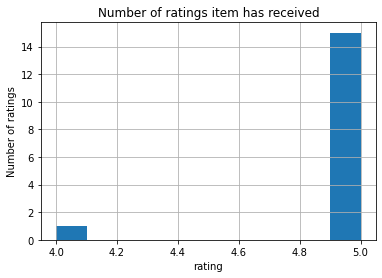

In [21]:
import matplotlib.pyplot as plt
#%matplotlib notebook
df1.loc[df1['product_id'] == '18796df281656da4036dd926561a6030']['review_score'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings item has received')
plt.show();